In [1]:
import os
os.getcwd()

'C:\\Users\\Mohit Mathur\\Customer Segmentation - Portfolio Project'

# Customer Segmentation Project - Executive Summary #

This project applies RFM (Recency, Frequency, Monetary) analysis combined with K-Means clustering to segment customers based on purchasing behavior using transactional retail data.
After evaluating multiple clustering configurations using the Elbow Method and Silhouette Score, four customer segments were selected as the optimal balance between model quality, interpretability, and business usability.

The analysis revealed strong revenue concentration across a small group of high-value customers. Although the “Regular Customers” segment contributed the largest total revenue due to its size, a very small “VIP Champions” segment (only 13 customers) generated nearly 19% of total revenue, highlighting the importance of targeted retention strategies.

### Key business insights include: ###

- Identification of a high-value VIP segment responsible for disproportionate revenue contribution.

- Discovery of a loyal customer segment with strong upsell potential.

- Isolation of an at-risk customer group suitable for re-engagement campaigns.

- Clear segmentation enabling targeted marketing, improved retention strategies, and optimized marketing spend.

This project demonstrates how unsupervised learning can be translated into actionable business strategies that directly impact revenue growth and customer lifetime value.

In [5]:
# Importing important libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
def load_and_clean_data(file_path):
    """
    Load the data (CSV or Excel) and perform basic cleaning:
    - Convert date columns to datetime
    - Drop duplicates and rows with missing values
    - Remove negative or zero quantities or prices
    - Calculate total line price
    """
    
    #  Detect file type by extension
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path, encoding="utf-8-sig")
    else:
        df = pd.read_excel(file_path)
        
    # Trime whitespace in object columns
    obj_cols = df.select_dtypes(include='object').columns
    for col in obj_cols:
        df[col] = df[col].str.strip()
        
    # Convert InvoiceDate to datetime if it exists
    if 'InvoiceDate' in df.columns:
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
        
    # Drop duplicates
    df.drop_duplicates(inplace=True)
    
    # Drop rows with missing values in critical columns
    df.dropna(subset=['CustomerID', 'InvoiceDate', 'Quantity', 'UnitPrice'], inplace = True)
    
    # Convert quantity and price to numeric and remove invalid entries
    df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
    df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors='coerce')
    df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
    
    # Calculate total line price
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
    
    return df
    

In [7]:
def create_rfm_features(df):
    """
    Compute Recency, Frequency, Monetary (RFM) values per customer:
    - Recency: days since last purchase relative to dataset max date
    - Frequency: number of invoices
    - Monetary: total spend
    """
    
    # Reference date is one day after the last invoice
    reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
    rfm = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (reference_date - x.max()).days,
        'InvoiceNo': 'nunique',
        'TotalPrice': 'sum'
    })
    rfm.columns = ['Recency', 'Frequency', 'Monetary']
    return rfm

In [8]:
def scale_features(features):
    """
    Standardize the RFM features for clustering
    """
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    return scaled_features, scaler

In [9]:
def optimal_k_elbow_silhouette(data, k_range=(2,10)):
    """
    Determine the optimal number of clusters using the elbow method and silhouette scores.
    Return the best k and associated metrics.
    """
    
    inertia = []
    silhouette_scores = []
    ks = list(range(k_range[0], k_range[1] + 1))
    
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state = 42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
        labels = kmeans.labels_
        sil_score = silhouette_score(data,labels)
        silhouette_scores.append(sil_score)
        
    # Plot elbow and silhouette graphs
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(ks, inertia, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia (SSE)')
    plt.title('Elbow Method')
    
    plt.subplot(1,2,2)
    plt.plot(ks, silhouette_scores, 'ro-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis')
    
    plt.tight_layout()
    plt.show()
    
    # Choose k corresponding to highest silhouette score
    best_k = ks[np.argmax(silhouette_scores)]
    return best_k, inertia, silhouette_scores
    
    

In [10]:
def cluster_customers(scaled_features, n_clusters):
    
    """
    Fit KMeans with n_clusters and return labels and the model.
    """
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    return labels, kmeans

In [11]:
def prepare_classification_data(rfm, labels):
    
    """
    Prepare features and target for classification by combining RFM with cluster labels.
    """
    features = rfm.copy()
    features['Cluster'] = labels
    X = features.drop('Cluster', axis=1)
    y = features['Cluster']
    return X,y

In [12]:
def evaluate_classifiers(X,y):
    """
    Train and evaluate multiple classifcation algorithms to predict cluster labels.
    Prints accuracy and classification reports.
    Performs basic hyperparameter tuning via GridSearchCV.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    
    models = {
        'LogisticRegression' : (LogisticRegression(max_iter=1000),{
            'C' : [0.1,1.0,10.0],
            'solver' : ['lbfgs']
        }),
        'RandomForest' : (RandomForestClassifier(), {
            'n_estimators' : [100,200],
            'max_depth' : [None, 5, 10]
        }),
        'KNN' : (KNeighborsClassifier(), {
            'n_neighbors' : [3,5,7],
            'weights' : ['uniform', 'distance']
        }),
        'SVM' : (SVC(), {
            'C' : [0.1,1.0,10.0],
            'kernel' : ['linear', 'rbf']
        }),
        'DecisionTree' : (DecisionTreeClassifier(), {
            'max_depth' : [None, 3,5,7],
            'min_samples_split' : [2,5,10]
        })
    }
    
    results = {}
    
    for name, (model,params) in models.items():
        print(f"\nTraining and tuning {name}...")
        grid = GridSearchCV(model, params, cv=5, scoring='accuracy')
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"Best params for {name} : {grid.best_params_}")
        print(f"Accuracy: {acc:.4f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        results[name] = {
            'best_params' : grid.best_params_,
            'accuracy' : acc,
            'model' : best_model
        }
    
    return results

In [28]:
# scaled_rfm already computed
results = []

for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(scaled_rfm)

    sil = silhouette_score(scaled_rfm, labels)
    sse = km.inertia_
    sizes = pd.Series(labels).value_counts().sort_index().values
    min_cluster_size = pd.Series(labels).value_counts().min()

    results.append({
        "k": k,
        "sse": sse,
        "silhouette": sil,
        "min_cluster_size": int(min_cluster_size)
    })

k_eval = pd.DataFrame(results).sort_values("k")
k_eval

,k,sse,silhouette,min_cluster_size
0,2,9356.670424,0.560401,1101
1,3,5501.487300,0.585324,14
2,4,4096.300211,0.616228,13
3,5,3119.789860,0.616500,6
4,6,2473.793364,0.598289,2
5,7,2023.644455,0.517088,2
6,8,1798.860082,0.491211,3
7,9,1468.787102,0.478438,2
8,10,1333.109622,0.444816,2


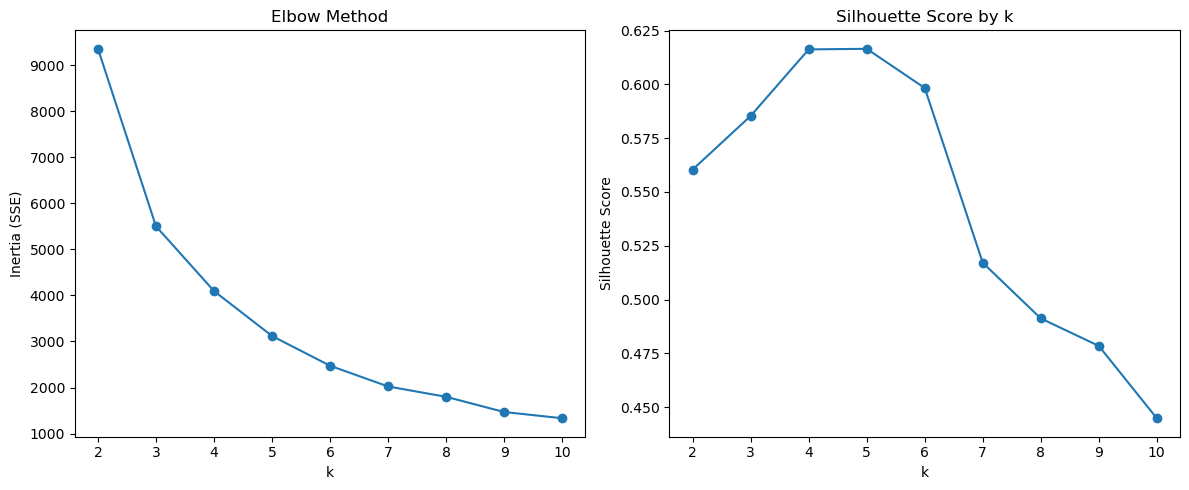

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(k_eval["k"], k_eval["sse"], marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method")

plt.subplot(1,2,2)
plt.plot(k_eval["k"], k_eval["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score by k")

plt.tight_layout()
plt.show()

### Cluster Selection Justification:  ###
I evaluated k values from 2 to 10 using both the elbow method (SSE) and silhouette score. The SSE curve shows diminishing improvement beyond k=4, indicating an elbow around 4–5 clusters. While k=5 marginally improves silhouette score, it creates extremely small clusters (as low as 6 customers), which are not actionable for business use. Therefore, k=4 was selected as the optimal balance between clustering quality, interpretability, and segment usability.

In [30]:
k_eval[k_eval["min_cluster_size"] >= 10].sort_values("silhouette", ascending=False)

,k,sse,silhouette,min_cluster_size
2,4,4096.300211,0.616228,13
1,3,5501.487300,0.585324,14
0,2,9356.670424,0.560401,1101


In [31]:
df = load_and_clean_data("data/Online_Retail.csv")

# 2. Derive RFM table
rfm = create_rfm_features(df)

# 3. Scale the features
scaled_rfm, scaler = scale_features(rfm)

# 4. Choose number of clusters (e.g. 4)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(scaled_rfm)
rfm['Cluster'] = labels

# 5. Evaluate silhouette score and inertia
sse = kmeans.inertia_
sil = silhouette_score(scaled_rfm, labels)
print(f"Chosen k={k}: SSE={sse:.0f}, silhouette={sil:.3f}")

# 6. Profile clusters: count, mean RFM values
cluster_profile = rfm.groupby("Cluster").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean"
})

cluster_profile["Count"] = rfm.groupby("Cluster").size()

cluster_profile.reset_index(inplace=True)

cluster_profile

C:\Users\Mohit Mathur\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Chosen k=4: SSE=4096, silhouette=0.616


,Cluster,Recency,Frequency,Monetary,Count
0,0,43.702685,3.682711,1353.625312,3054
1,1,248.075914,1.552015,478.848773,1067
2,2,7.384615,82.538462,127187.959231,13
3,3,15.500000,22.333333,12690.500392,204


In [21]:
revenue_share = rfm.groupby("Cluster")["Monetary"].sum()

total_revenue = revenue_share.sum()

revenue_pct = (revenue_share / total_revenue * 100).round(2)

revenue_summary = pd.concat([revenue_share, revenue_pct], axis=1)
revenue_summary.columns = ["TotalRevenue", "RevenuePercentage"]

revenue_summary

,TotalRevenue,RevenuePercentage
Cluster,,
0,4133971.703,46.52
1,510931.641,5.75
2,1653443.470,18.60
3,2588862.080,29.13


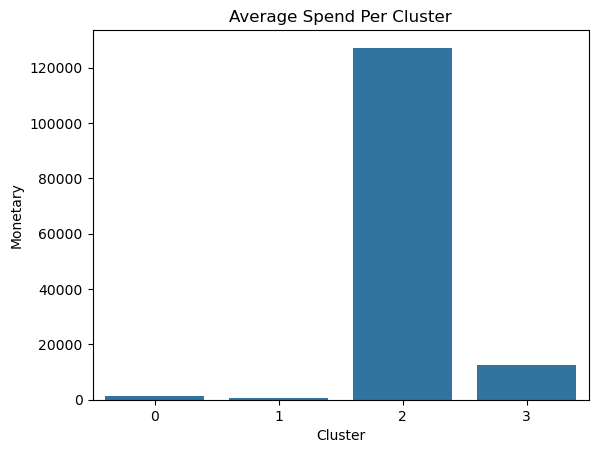

In [22]:
import seaborn as sns

sns.barplot(data=cluster_profile, x="Cluster", y="Monetary")
plt.title("Average Spend Per Cluster")
plt.show()

In [33]:
segment_map = {
    0: "Regular Customers",
    1: "At Risk Customers",
    2: "VIP Champions",
    3: "Loyal High Value"
}

rfm["Segment"] = rfm["Cluster"].map(segment_map)

In [34]:
rfm["Segment"].value_counts()

Segment
Regular Customers    3054
At Risk Customers    1067
Loyal High Value      204
VIP Champions          13
Name: count, dtype: int64

In [35]:
segment_summary = rfm.groupby("Segment").agg({
    "Recency":"mean",
    "Frequency":"mean",
    "Monetary":"mean",
    "Cluster":"count"
}).rename(columns={"Cluster":"CustomerCount"}).sort_values("Monetary", ascending=False)

segment_summary

,Recency,Frequency,Monetary,CustomerCount
Segment,,,,
VIP Champions,7.384615,82.538462,127187.959231,13
Loyal High Value,15.500000,22.333333,12690.500392,204
Regular Customers,43.702685,3.682711,1353.625312,3054
At Risk Customers,248.075914,1.552015,478.848773,1067


In [43]:
sns.set_style("whitegrid")

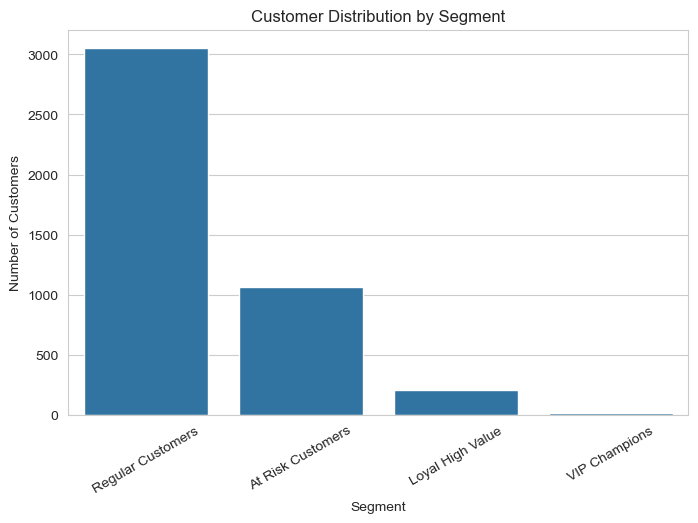

In [45]:
# Customer Distribution by Segment
# Shows market size of each segment.

plt.figure(figsize=(8,5))
sns.barplot(
    x=rfm["Segment"].value_counts().index,
    y=rfm["Segment"].value_counts().values
)

plt.title("Customer Distribution by Segment")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=30)
plt.show()

## Most customers belong to Regular segment, while VIP segment is very small but valuable. ##

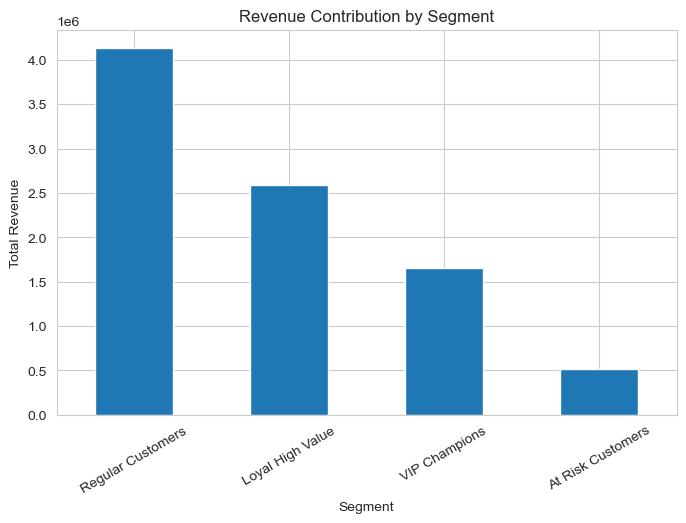

In [46]:
# Revenue Contribution by Segment
segment_revenue = rfm.groupby("Segment")["Monetary"].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
segment_revenue.plot(kind="bar")

plt.title("Revenue Contribution by Segment")
plt.xlabel("Segment")
plt.ylabel("Total Revenue")
plt.xticks(rotation=30)
plt.show()

## Small VIP and Loyal segments contribute disproportionately to revenue. ##

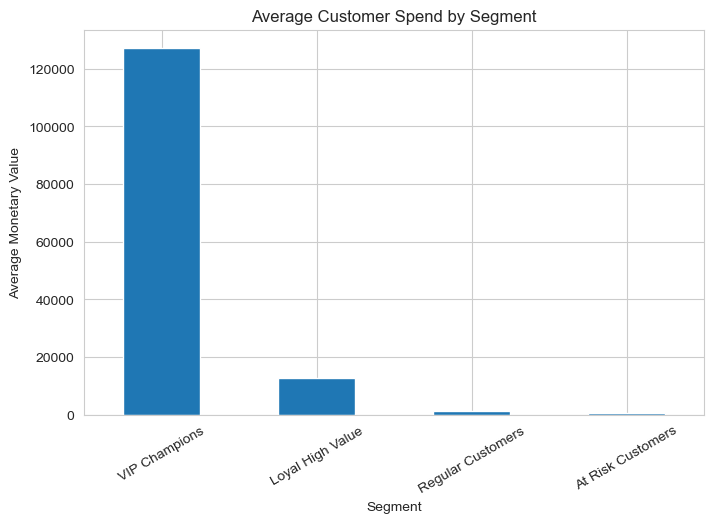

In [47]:
# Average Spend Per Customer
# Shows per-customer value

segment_avg_spend = rfm.groupby("Segment")["Monetary"].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
segment_avg_spend.plot(kind="bar")

plt.title("Average Customer Spend by Segment")
plt.xlabel("Segment")
plt.ylabel("Average Monetary Value")
plt.xticks(rotation=30)
plt.show()

## VIP customers are exponentially more valuable per customer. ##

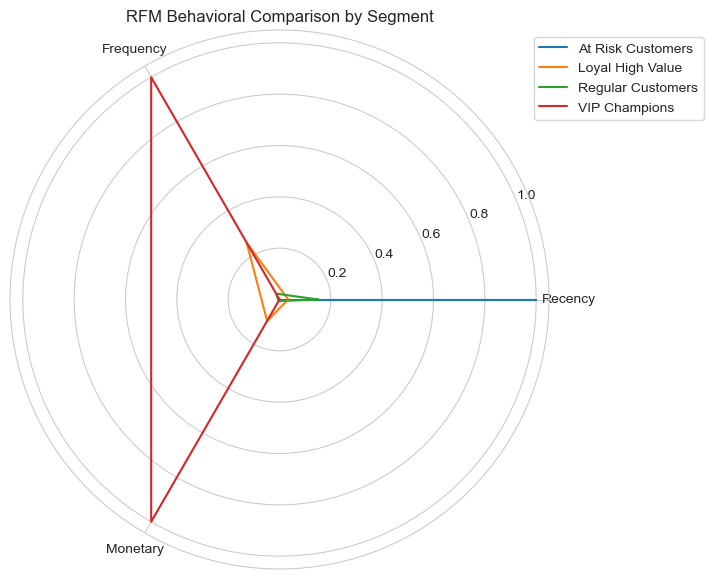

In [48]:
# RFM Radar Chart (Behavior Comparison)
# This is HIGH IMPACT visually.

rfm_means = rfm.groupby("Segment")[["Recency","Frequency","Monetary"]].mean()

# Normalize for radar
rfm_norm = (rfm_means - rfm_means.min()) / (rfm_means.max() - rfm_means.min())

labels = rfm_norm.columns
num_vars = len(labels)

angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(7,7))

for segment in rfm_norm.index:
    values = rfm_norm.loc[segment].tolist()
    values += values[:1]
    plt.polar(angles, values, label=segment)

plt.xticks(angles[:-1], labels)
plt.title("RFM Behavioral Comparison by Segment")
plt.legend(loc="upper right", bbox_to_anchor=(1.3,1))
plt.show()

## Each segment has a distinct behavioral fingerprint. ##

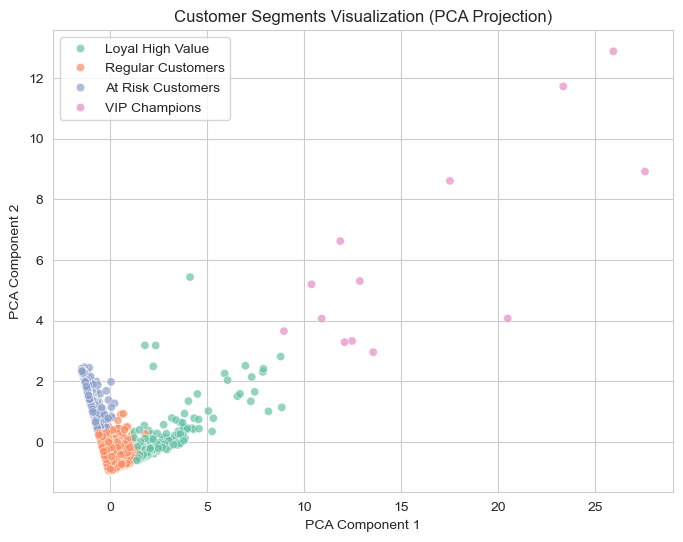

In [49]:
# PCA Cluster Visualization (Model Visualization)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_rfm)

plt.figure(figsize=(8,6))

sns.scatterplot(
    x=pca_components[:,0],
    y=pca_components[:,1],
    hue=rfm["Segment"],
    palette="Set2",
    alpha=0.7
)

plt.title("Customer Segments Visualization (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

## Customers naturally separate into behavioral clusters. ##

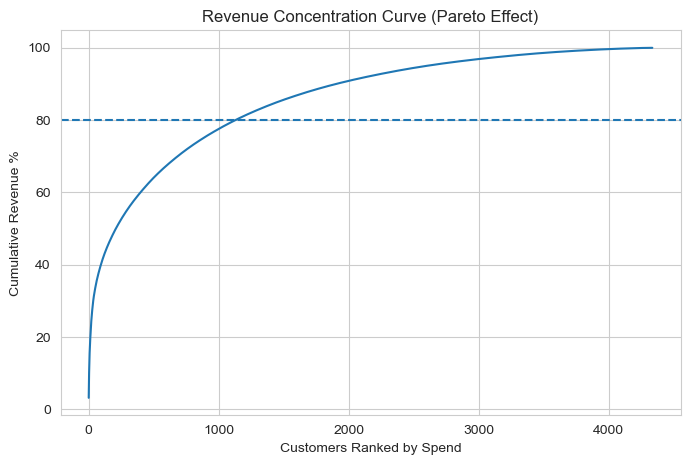

In [50]:
# Revenue Concentration Curve (Pareto Effect)
# This proves VIP Importance

rfm_sorted = rfm.sort_values("Monetary", ascending=False)

rfm_sorted["cum_revenue_pct"] = (
    rfm_sorted["Monetary"].cumsum() / rfm_sorted["Monetary"].sum()
) * 100

plt.figure(figsize=(8,5))
plt.plot(rfm_sorted["cum_revenue_pct"].values)

plt.axhline(80, linestyle="--")
plt.title("Revenue Concentration Curve (Pareto Effect)")
plt.xlabel("Customers Ranked by Spend")
plt.ylabel("Cumulative Revenue %")
plt.show()

## Small percentage of customers generate majority of revenue. ##